# **Land Type Classification using Sentinel-2 Satellite Images** #
This project aims to develop a **Deep Neural Network (DNN)** model for **Land Use and Land Cover (LULC) classification** across major areas in **Egypt**. Utilizing the rich multispectral data provided by the **Sentinel-2** satellite mission, the model will accurately categorize different land types (e.g., agriculture, urban, water bodies, desert/bare soil) at a high spatial resolution. This is a critical task for effective environmental monitoring, urban planning, and resource management in a country with a uniquely diverse and rapidly changing landscape.

# **1. Problem Definition & Business Understanding**
## **Problem Definition**
Egypt's land is characterized by a high contrast between the fertile Nile Valley and Delta (about 4% of the total area) and the vast surrounding deserts (about 96%). **Accurate, up-to-date Land Use/Land Cover (LULC) maps** are essential for effective governance, but conventional ground surveys are expensive, slow, and labor-intensive for a country of this size.

The problem this project addresses is:

> **How can we efficiently and accurately classify major land types across Egypt at a high spatial resolution using Sentinel-2 satellite imagery to produce reliable, timely LULC maps for resource management, urban development monitoring, and environmental assessment?**

Specifically, traditional image processing methods often struggle with:
* **Spectral Similarity:** Distinguishing between classes with similar spectral signatures (e.g., some types of agriculture vs. natural vegetation, or different densities of urban development).
* **Scale and Complexity:** Handling the massive volume of high-resolution, multi-band images and the spectral diversity across a large geographic area like Egypt.

This project leverages the **high spectral (13 bands) and spatial (10m) resolution** of Sentinel-2 data, combined with the powerful feature extraction capabilities of Deep Neural Networks, to overcome these classification challenges and provide superior accuracy compared to conventional machine learning or unsupervised methods. 

## **Business Understanding**
Accurate LULC maps are a fundamental component for several critical sectors:

| Area | Application | Business Value/Impact |
| :---: | :---: | :---: |
| **Agriculture & Food Security** | Monitoring cultivated areas, assessing crop type distribution, and detecting land encroachment. | Optimizing irrigation (crucial in Egypt), improving yield prediction, and securing limited arable land. |
| **Urban Planning & Infrastructure** | Tracking the expansion of built-up areas and unauthorized construction. | Informing sustainable urban development, regulating expansion onto agricultural land, and efficient infrastructure planning. |
| **Water Resource Management** | Monitoring the extent of water bodies (e.g., lakes, coastlines, irrigation canals). | Assessing water availability, detecting changes due to climate or consumption, and managing coastal resources. |
| **Environmental Monitoring** | Mapping desertification, tracking natural vegetation, and evaluating environmental impact assessments. | Supporting national efforts to combat desertification and manage protected areas. |

**The ultimate business objective is to provide stakeholders (e.g., Ministry of Agriculture, Urban Planning Authorities, Environmental Agencies) with a reliable, scalable, and automated system to generate LULC information, leading to better-informed and data-driven policy decisions.**

# **2. Data Collection & Description** #

For this project, we are utilizing the **EuroSAT dataset**, a widely recognized benchmark for Land Use and Land Cover (LULC) classification based on imagery from the **Sentinel-2** satellite provided by the European Space Agency (ESA). While the project aims to classify land in Egypt, using EuroSAT provides a robust, pre-labeled, high-quality dataset derived from the target satellite source (Sentinel-2) for initial model development and training. This dataset is publicly available on platforms like Kaggle and consists of pre-labeled image patches representing different land cover classes.

The key strength of the EuroSAT dataset is its availability in two distinct formats, which will both be leveraged in this project:

1.  **Multispectral Data (.tif):** The primary data source. This consists of the **13 spectral bands** captured by the Sentinel-2 instrument. These bands, stored as `.tif` files, contain rich spectral information (including visible, near-infrared, and short-wave infrared bands) critical for robust land type discrimination using Deep Neural Networks. By utilizing the full 13-band data, the model gains access to the non-visible light spectrum, which is crucial for calculating indices like **NDVI** (Normalized Difference Vegetation Index) and achieving high classification accuracy. 
2.  **RGB Images (Visual):** A separate set of images, typically derived from combining the Red, Green, and Blue bands (Bands 4, 3, 2) of the Sentinel-2 imagery. These are 3-channel visual images that can be used for transfer learning, visual inspection, and potentially as a simplified input for specific model architectures.

## **Dataset Specifications**
* **Image size:** $64 \times 64$ pixels.
* **Source Satellite:** Sentinel-2 (ESA).
* **Data Formats Used:** 13-band `.tif` (Multispectral) and 3-channel RGB images.
* **Number of Classes:** **10** distinct land types:
    * Annual Crop
    * Forest
    * Herbaceous Vegetation
    * Highway
    * Industrial
    * Pasture
    * Permanent Crop
    * Residential
    * River
    * Sea/Lake
By utilizing the full **13-band multispectral data**, the model gains access to the non-visible light spectrum, which is crucial for calculating indices like **NDVI** (Normalized Difference Vegetation Index) and achieving high classification accuracy, especially for differentiating various forms of vegetation and bare soil/desert.

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.7 MB/s eta 0:00:00:00:0100:01


In [93]:
# --- 1. Standard Library Imports ---
import os
import time
import logging
import warnings
import pickle
from collections import Counter

# --- 2. Data Handling and Visualization ---
import numpy as np
import pandas as pd
import rasterio
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm

# --- 3. Scikit-learn and Utility Preprocessing ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# --- 4. TensorFlow and Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50 

# --- Environment Configuration and Logging Suppression ---

# Disable TensorFlow and Abseil logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress info/warnings from TF
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Disable Python warnings
warnings.filterwarnings('ignore')

# Disable specific library warnings (like transformers)
logging.getLogger("transformers").setLevel(logging.ERROR)

# Disable logging from all libraries
logging.disable(logging.CRITICAL)

In [3]:
eurosat_all_band_train = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSATallBands/train.csv')
eurosat_all_band_validation = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSATallBands/validation.csv')
eurosat_all_band_test = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSATallBands/test.csv')

In [4]:
eurosat_train = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSAT/train.csv')
eurosat_validation = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSAT/validation.csv')
eurosat_test = pd.read_csv('/kaggle/input/eurosat-dataset/EuroSAT/test.csv')

In [5]:
eurosat_all_band_train.shape , eurosat_all_band_validation.shape , eurosat_all_band_test.shape

((19317, 3), (5519, 3), (2759, 3))

In [6]:
eurosat_train.shape , eurosat_validation.shape , eurosat_test.shape

((18900, 4), (5400, 4), (2700, 4))

In [8]:
classes = eurosat_all_band_train['ClassName'].unique()
print(classes)

['PermanentCrop' 'HerbaceousVegetation' 'SeaLake' 'River' 'Forest'
 'AnnualCrop' 'Pasture' 'Highway' 'Residential' 'Industrial']


In [11]:
eurosat_all_band_train["Filename"] = eurosat_all_band_train["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSATallBands", x))
eurosat_all_band_test["Filename"] = eurosat_all_band_test["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSATallBands", x))
eurosat_all_band_validation["Filename"] = eurosat_all_band_validation["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSATallBands", x))

In [12]:
eurosat_train["Filename"] = eurosat_train["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSAT", x))
eurosat_test["Filename"] = eurosat_test["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSAT", x))
eurosat_validation["Filename"] = eurosat_validation["Filename"].apply(lambda x: os.path.join("/kaggle/input/eurosat-dataset/EuroSAT", x))

# **3. Exploratory Data Analysis** #

## **Land Type Samples**

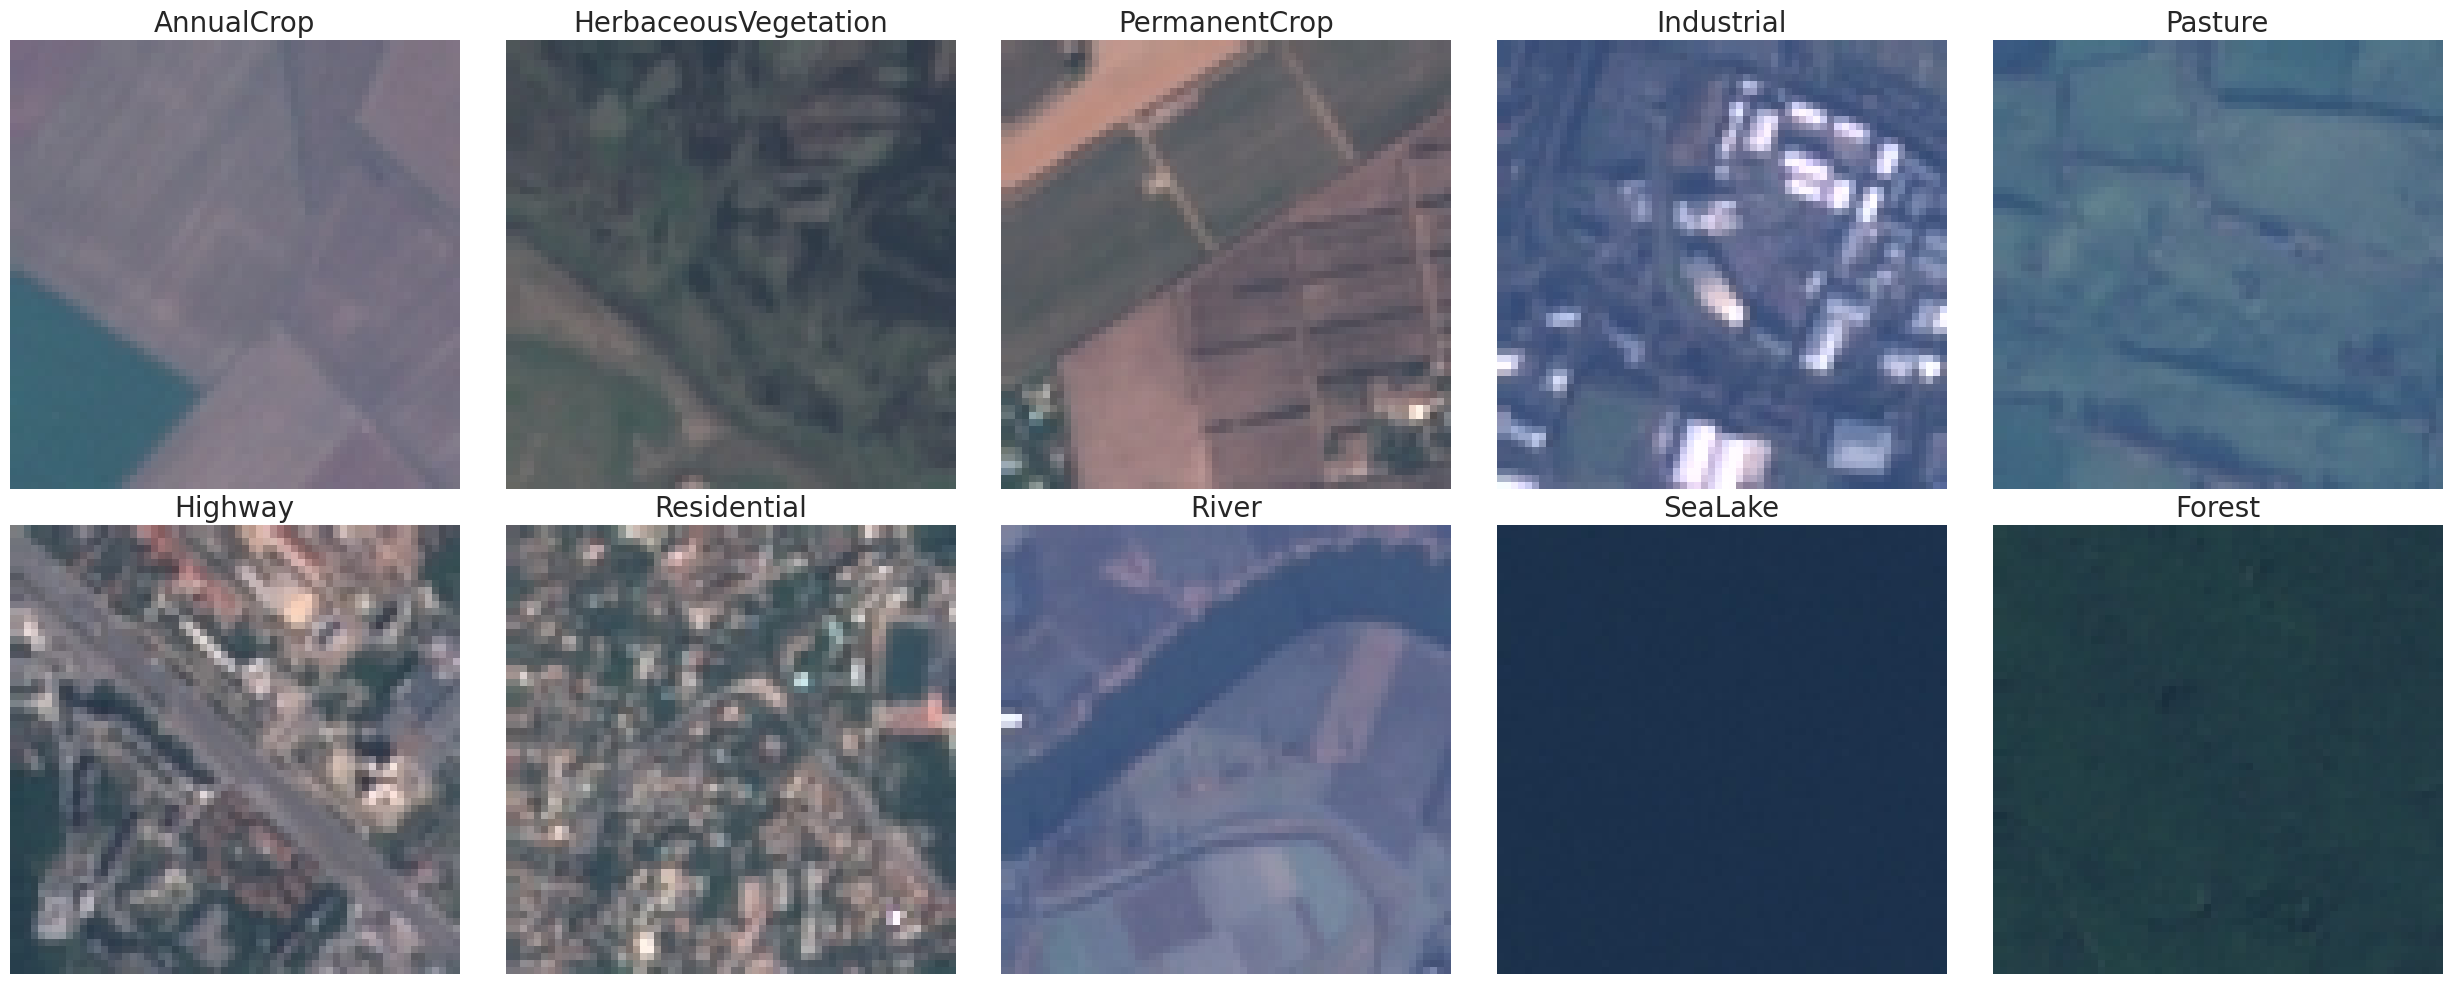

In [89]:
samples_per_class = 1
classes = eurosat_train['ClassName'].unique()

fig, axes = plt.subplots(2, 5, figsize=(25, 10))

for i, cls in enumerate(classes):
    row = i // 5
    col = i % 5
    
    class_images = eurosat_train[eurosat_train['ClassName'] == cls]['Filename'].tolist()
    selected = random.sample(class_images, samples_per_class)

    for full_path in selected:
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb = img / 255.0

        axes[row, col].imshow(rgb)
        axes[row, col].set_title(cls, fontsize=20)
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()

## **Adding NDVI, NDBI, & NDWI**

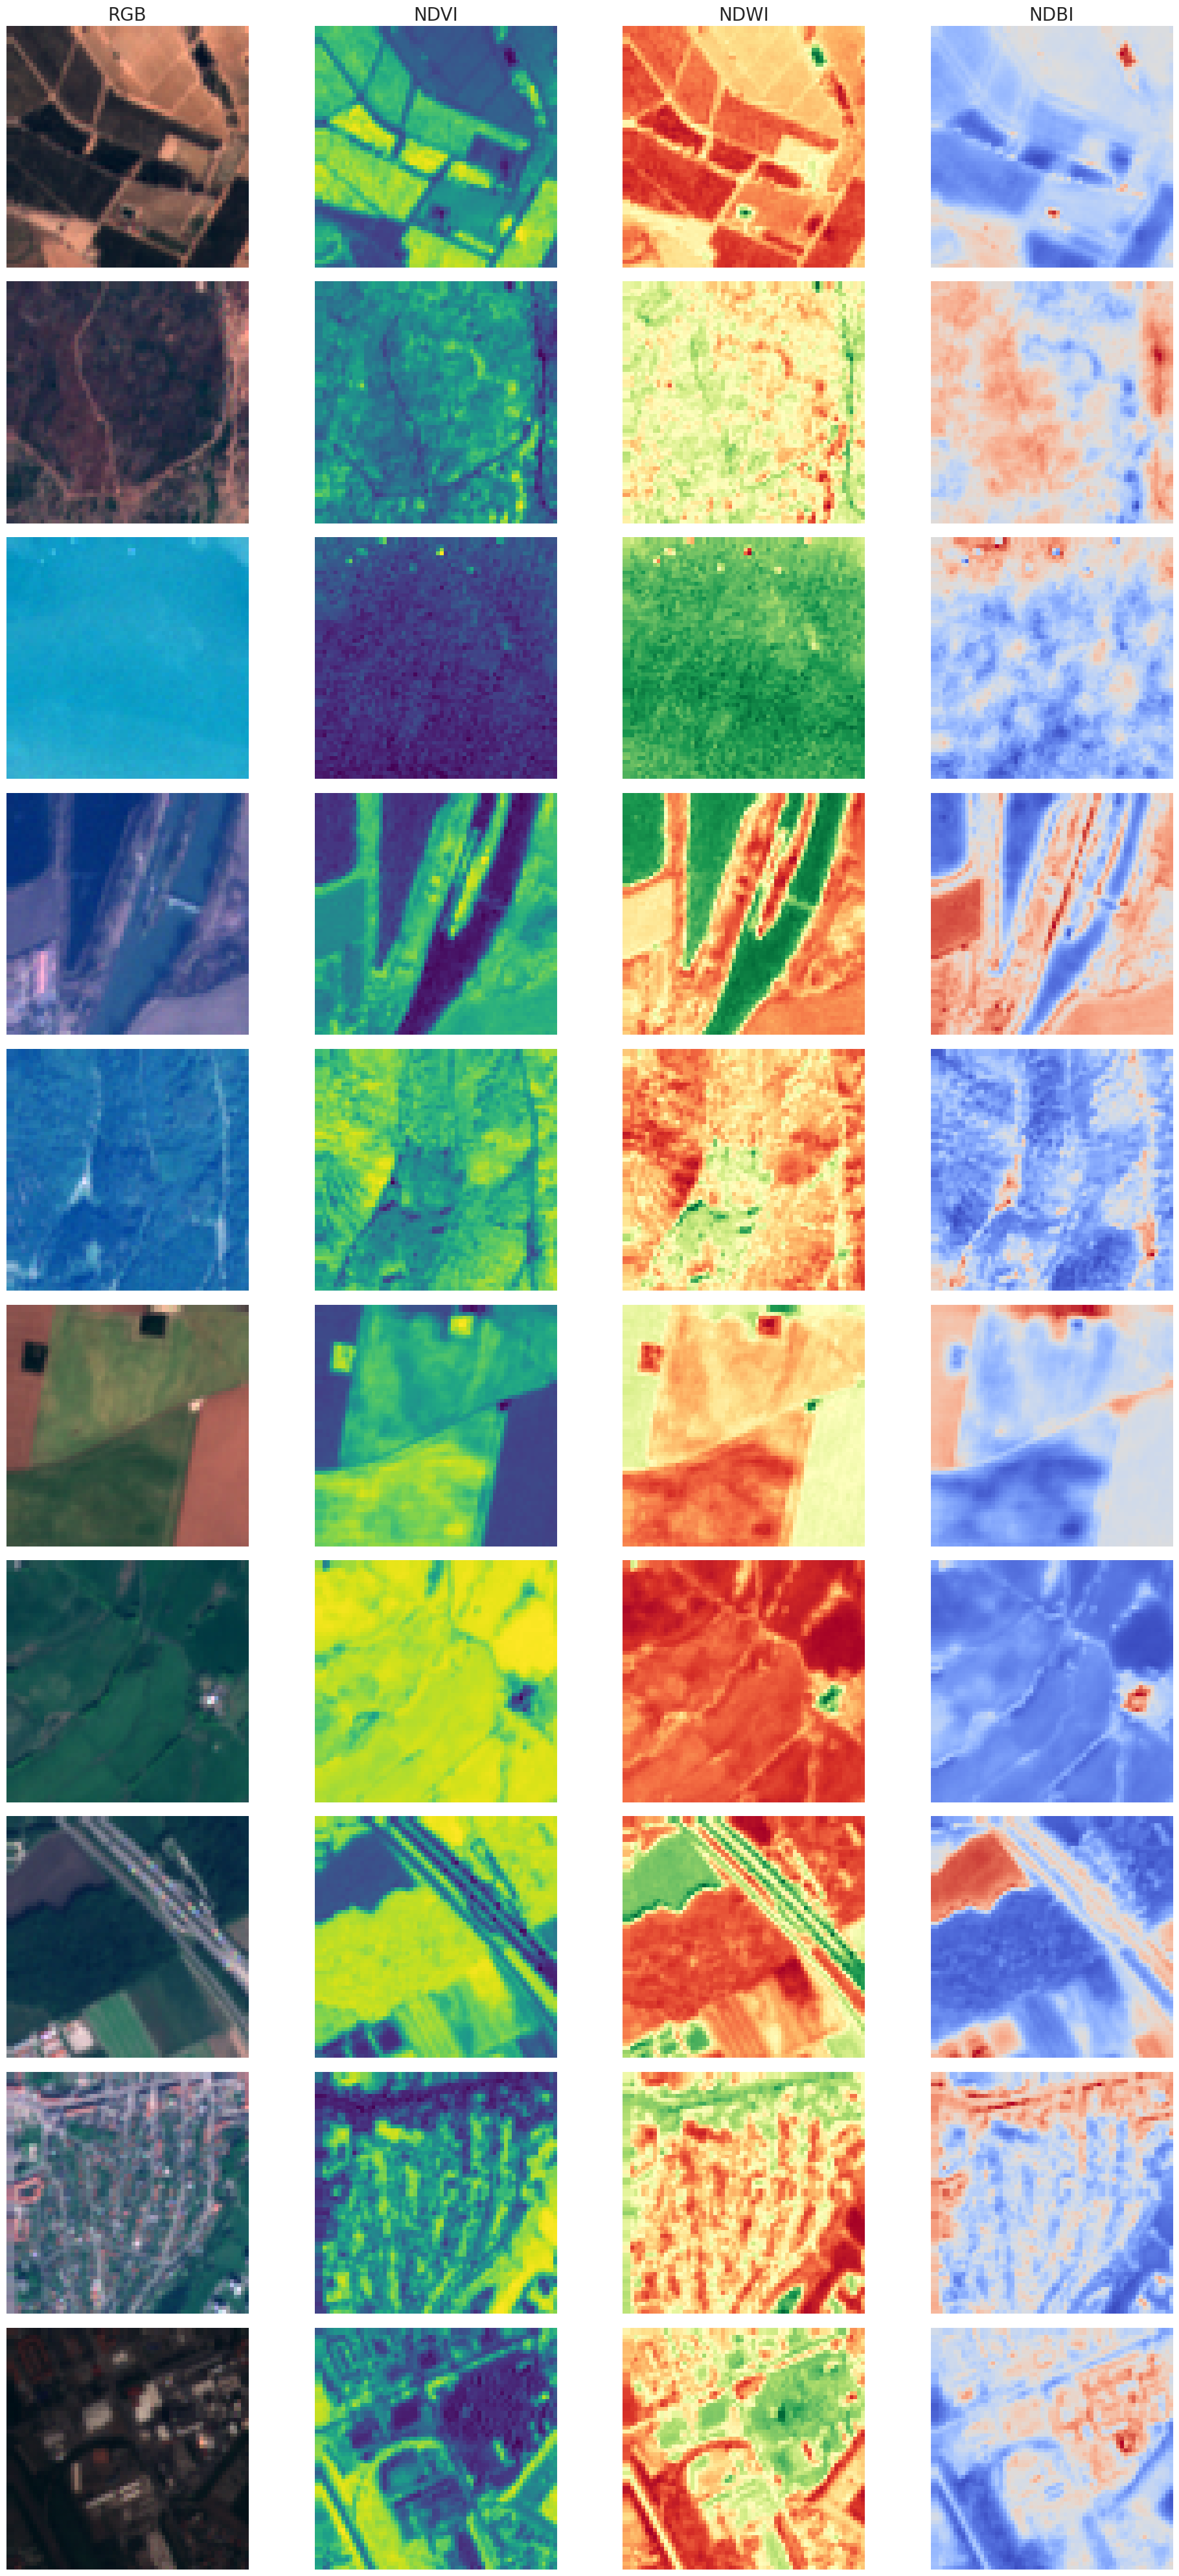

In [117]:
samples_per_class = 1
classes = eurosat_all_band_train['ClassName'].unique()
rep_titles = ["RGB", "NDVI", "NDWI", "NDBI"]
num_reps = len(rep_titles)
colormaps = [None, "viridis", "RdYlGn", "coolwarm" ]
fig, axes = plt.subplots(len(classes), num_reps, figsize=(num_reps * 5, len(classes) * 4))

def compute_indices(img):
    BLUE  = img[:, :, 1].astype(float)
    GREEN = img[:, :, 2].astype(float)
    RED   = img[:, :, 3].astype(float)
    NIR   = img[:, :, 7].astype(float)
    SWIR1 = img[:, :, 11].astype(float)  
    NDVI = (NIR - RED) / (NIR + RED + 1e-6)
    NDWI = (GREEN - NIR) / (GREEN + NIR + 1e-6)
    NDBI = (SWIR1 - NIR) / (SWIR1 + NIR + 1e-6)  
    return NDVI, NDWI, NDBI

for i, cls in enumerate(classes):
    class_images = eurosat_all_band_train[eurosat_all_band_train['ClassName'] == cls]['Filename'].tolist()
    selected = random.sample(class_images, samples_per_class)
    full_path = selected[0]
    with rasterio.open(full_path) as src:
        img = src.read()                    
        img = np.transpose(img, (1, 2, 0)) 
    
    R = img[:, :, 3].astype(float)
    G = img[:, :, 2].astype(float)
    B = img[:, :, 1].astype(float)
    
    all_bands = np.stack([R, G, B], axis=-1)
    global_min = all_bands.min()
    global_max = all_bands.max()
    rgb = (all_bands - global_min) / (global_max - global_min + 1e-6)
    
    rgb = np.clip(rgb, 0, 1)
    
    NDVI, NDWI, NDBI = compute_indices(img)
    reps = [rgb, NDVI, NDWI, NDBI]
    
    for col in range(num_reps):
        ax = axes[i, col]
        rep_img = reps[col]
        if rep_img.ndim == 2:
            cmap = colormaps[col]
            ax.imshow(rep_img, cmap=cmap)
        else:
            ax.imshow(rep_img)
        if i == 0:
            ax.set_title(rep_titles[col], fontsize=20)
        if col == 0:
            ax.set_ylabel(cls, fontsize=18)
        ax.axis("off")

plt.tight_layout()
plt.show()

## **Land Type Distribution**

1.  **General Balance:** The dataset is considered **relatively balanced** but not perfectly uniform. Most of the 10 classes have a sample count of either 3,000 or 2,500, indicating that the dataset was intentionally curated to prevent severe class imbalance issues.
2.  **Majority Class:** The class **`SeaLake`** is the most represented class, with **3,595** samples. This is slightly higher than the second tier of classes.
3.  **Tier 2 (3,000 Samples):** Four classes share the second-highest count of **3,000** samples each: `AnnualCrop`, `Forest`, `HerbaceousVegetation`, and `Residential`.
4.  **Tier 3 (2,500 Samples):** Four classes have **2,500** samples: `Highway`, `Industrial`, `PermanentCrop`, and `River`.
5.  **Minority Class:** The class **`Pasture`** is the least represented, with **2,000** samples.

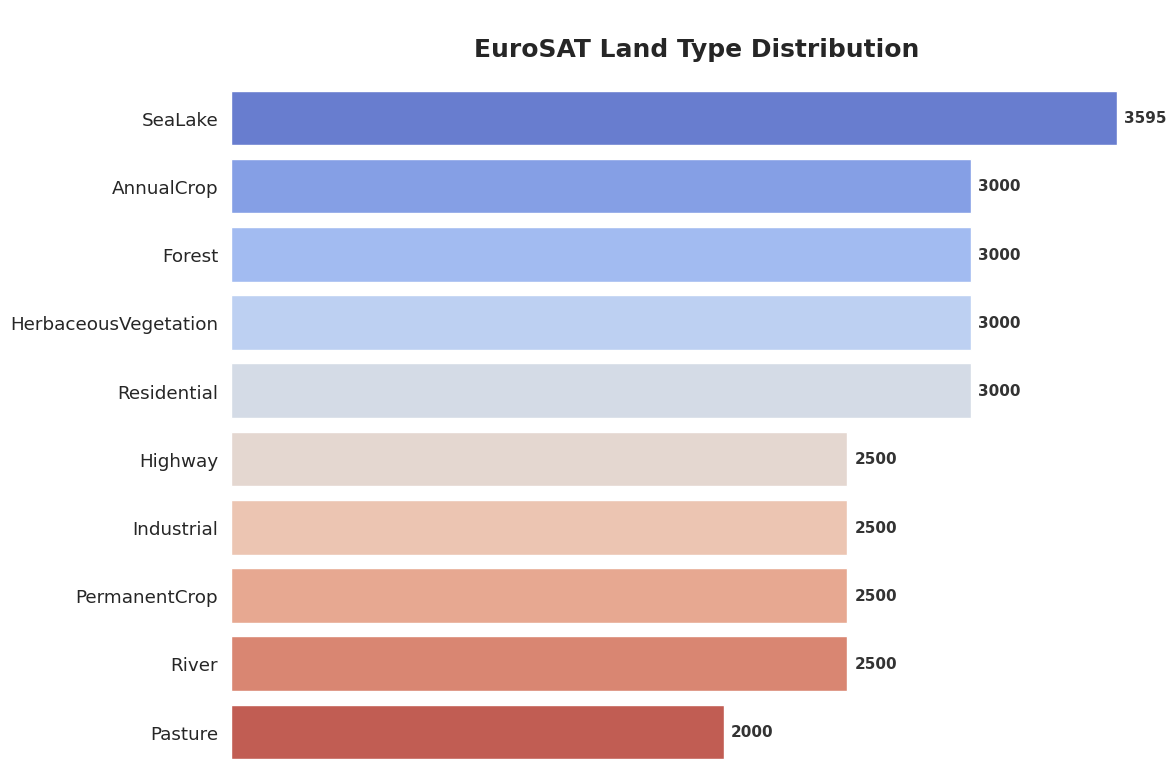

In [16]:
train_counts = eurosat_all_band_train['ClassName'].value_counts()
val_counts = eurosat_all_band_validation['ClassName'].value_counts()
test_counts = eurosat_all_band_test['ClassName'].value_counts()

total_counts = train_counts.add(val_counts, fill_value=0).add(test_counts, fill_value=0).sort_values(ascending=False)

sns.set(style='white', font_scale=1.2)
palette = sns.color_palette("coolwarm", len(total_counts)) 

fig, ax = plt.subplots(figsize=(12, 8))

bars = sns.barplot(x=total_counts.values, y=total_counts.index, palette=palette, ax=ax)

for bar in bars.patches:
    width = bar.get_width()
    bars.annotate(f'{int(width)}',
                  xy=(width, bar.get_y() + bar.get_height() / 2),
                  xytext=(5, 0),
                  textcoords='offset points',
                  ha='left', va='center',
                  fontsize=11, color='#333333', weight='bold')

ax.set_title('\nEuroSAT Land Type Distribution', fontsize=18, weight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('', fontsize =12)
ax.set_xticks([])
sns.despine(left=True, bottom=True)  

plt.tight_layout()
plt.show()


## **Top Spectral Bands per Land Type**

Analyzing which spectral bands (out of the 13 available from Sentinel-2) are most effective for classifying each land type is **critical** for building an efficient and accurate model.

In simple terms, this analysis helps us to:

1.  **Be More Efficient (Smarter Data):**
    * **Focus on the Best Features:** We can identify and use only the bands that provide the most information for telling classes apart.
    * **Speed Up Training:** Using fewer, but better, bands means the Deep Neural Network (DNN) has less data to process, making the training faster and less memory-intensive.

2.  **Make the Model Better (More Accurate):**
    * **Reduce Confusion:** It helps highlight the unique **"spectral fingerprint"** of each land type. For example, by confirming that **Band 8 (Near-Infrared)** is crucial for vegetation, we ensure the model uses the best information to distinguish a `Forest` from a `River`. 
    * **Prevent Overfitting:** By ignoring noisy or irrelevant bands, the model learns the core properties of the land, making it more reliable when classifying new images.

3.  **Understand Why (Interpretability):**
    * We gain insight into *why* the model is making its decisions, confirming that the classification is based on real-world physics and remote sensing principles, not just random patterns in the data.

In [ ]:
band_names = [
    'B01 - Coastal Aerosol',
    'B02 - Blue',
    'B03 - Green',
    'B04 - Red',
    'B05 - Red Edge 1',
    'B06 - Red Edge 2',
    'B07 - Red Edge 3',
    'B08 - NIR',
    'B8A - Narrow NIR',
    'B09 - Water Vapor',
    'B10 - SWIR - Cirrus',
    'B11 - SWIR 1',
    'B12 - SWIR 2']

In [13]:
def extract_band_means(row):
    with rasterio.open(row['Filename']) as src:
        bands = src.read()
        return pd.Series(bands.mean(axis=(1, 2)))

band_means_df = eurosat_all_band_train.apply(extract_band_means, axis=1)
band_means_df.columns = band_names

band_means_df['ClassName'] = eurosat_all_band_train['ClassName'].values

In [41]:
band_means = band_means_df.groupby('ClassName').mean().astype(int)

In [40]:
def analyze_top_mean_bands(band_means_df):
    sorted_bands_list = []
    
    for class_name in band_means_df.index:
        means = band_means_df.loc[class_name]
        sorted_bands = means.sort_values(ascending=False).index
        sorted_bands_list.append(sorted_bands.tolist())

    rank_columns = [f'{i}th' for i in range(1, len(band_names) + 1)]
    
    ranking_df = pd.DataFrame(
        sorted_bands_list ,
        index=band_means_df.index,
        columns=rank_columns
    )
    return ranking_df
    

ranking_results_df = analyze_top_mean_bands(band_means)
ranking_results_df.iloc[:,:5].T

ClassName,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
1th,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B01 - Coastal Aerosol
2th,B07 - Red Edge 3,B07 - Red Edge 3,B08 - NIR,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B02 - Blue
3th,B08 - NIR,B08 - NIR,B07 - Red Edge 3,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B03 - Green
4th,B06 - Red Edge 2,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B06 - Red Edge 2,B04 - Red
5th,B10 - SWIR - Cirrus,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B01 - Coastal Aerosol,B05 - Red Edge 1


## **Mean Spectral Band Values per Land Type**
1.  **Vegetation:** Classes like `Forest`, `AnnualCrop`, and `Pasture` show the darkest purple (highest reflectance) in the **NIR (B08/B8A)** and **Red Edge (B05-B07)** regions. This is the characteristic signature of healthy plants.
2.  **Water:** Classes like `SeaLake` and `River` show the lowest reflectance (lightest color/small numbers) in the **NIR (B08)** and **SWIR (B11/B12)** regions, indicating strong absorption, which is typical for water.
3.  **Built-up Areas:** Classes like `Industrial` and `Residential` show high and varied reflectance across the spectrum, often peaking in the **SWIR (B11/B12)** bands.

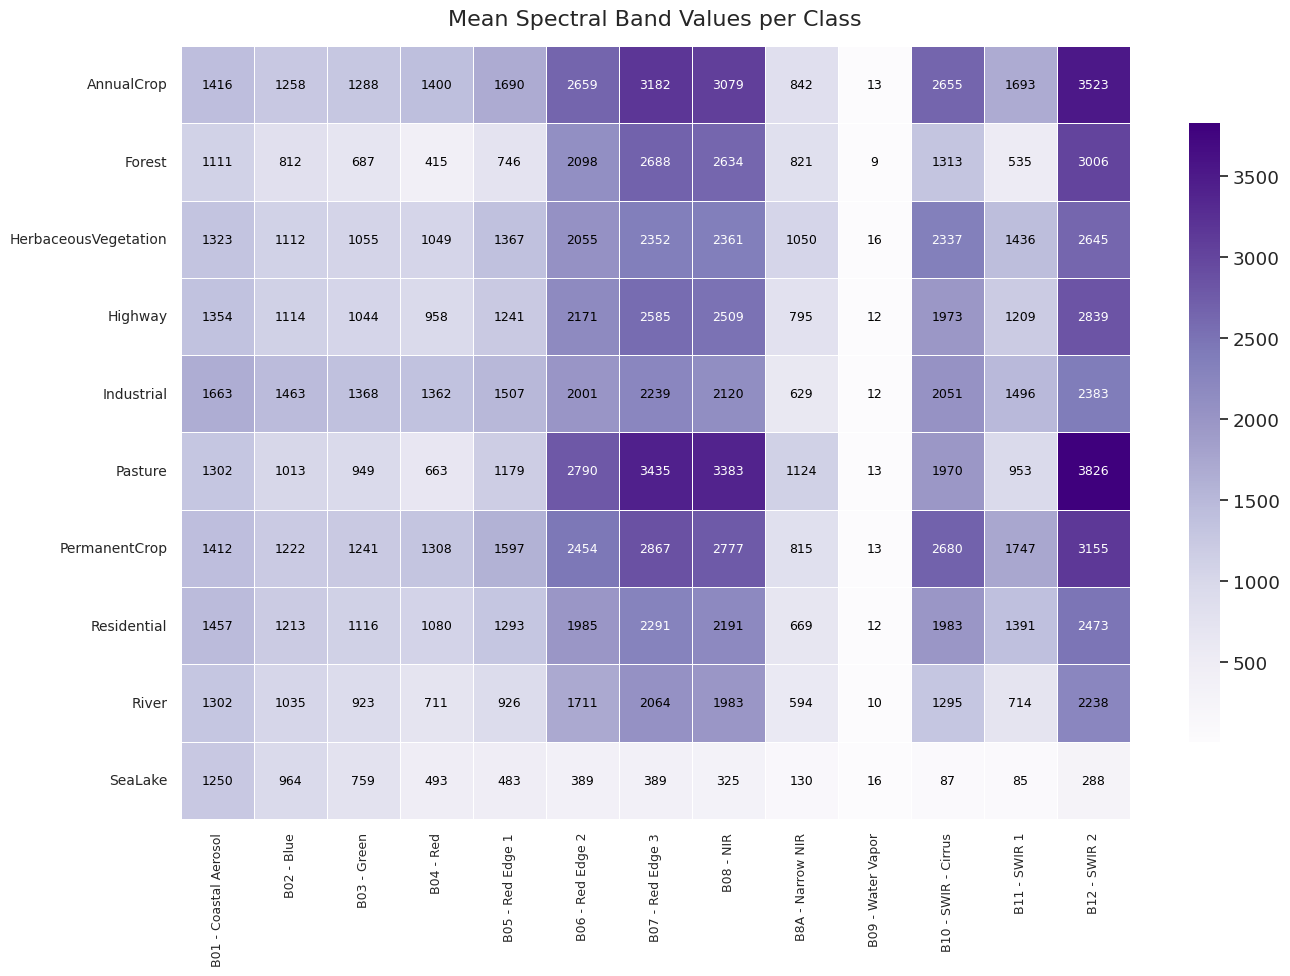

In [14]:
plt.figure(figsize=(14, 10))

ax = sns.heatmap(
    band_means,
    fmt=".0f",
    cmap="Purples",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "", "shrink": 0.8}
)

cmap = plt.get_cmap("Purples")
norm = plt.Normalize(band_means.values.min(), band_means.values.max())

for i in range(band_means.shape[0]):          
    for j in range(band_means.shape[1]):      
        value = band_means.values[i, j]
        color = cmap(norm(value))
        brightness = (color[0]*0.299 + color[1]*0.587 + color[2]*0.114)
        text_color = "white" if brightness < 0.55 else "black"

        ax.text(
            j + 0.5, i + 0.5,
            f"{value}",
            ha="center", va="center",
            color=text_color, fontsize=9
        )

plt.title("Mean Spectral Band Values per Class", fontsize=16, pad=15)
plt.xlabel("")
plt.ylabel("")

num_cols = band_means.shape[1]
ax.set_xticks(np.arange(num_cols) + 0.5)
ax.set_xticklabels(band_names, rotation=90, ha="center", fontsize=9)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## **Dimensionality Reduction of Multispectral Data Using PCA**

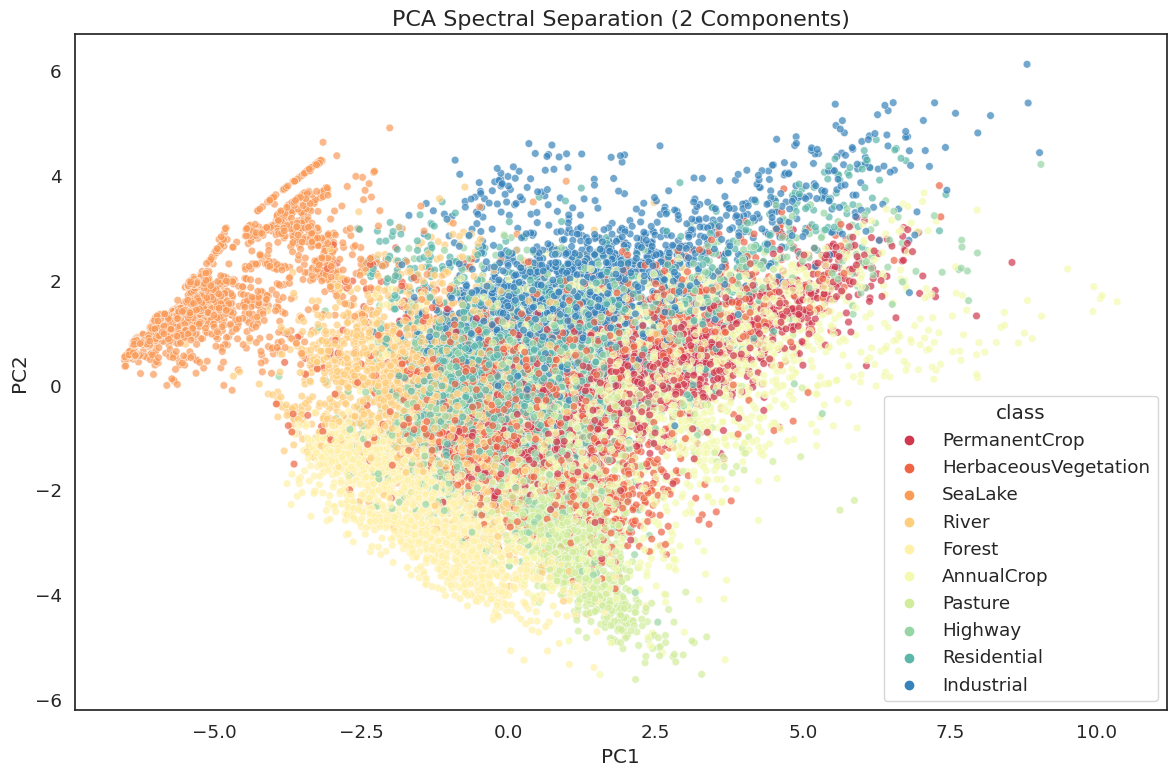

In [63]:
def visualize_spectral_separation_pca(band_means_df):
    X = band_means_df.iloc[:, :13].values
    y = band_means_df.iloc[:, 13].values
    
    X_scaled = StandardScaler().fit_transform(X)
    pcs = PCA(n_components=2).fit_transform(X_scaled)
    
    pca_df = pd.DataFrame({
        "PC1": pcs[:, 0],
        "PC2": pcs[:, 1],
        "class": y
    })
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2",
        hue="class",
        palette="Spectral",
        s=30, alpha=0.7
    )
    plt.title("PCA Spectral Separation (2 Components)", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_spectral_separation_pca(band_means_df)


# **3. Images Preprocessing & Feature Engineering** #

## **Step 1: Image Loading** ##

In [5]:
def load_multiband_image_py(path, label):
    path = path.numpy().decode("utf-8")
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
    channels = img.shape[0]

    img = np.transpose(img, (1, 2, 0))
    return img, label

In [6]:
def load_multiband_image(path, label):
    img, label = tf.py_function(
        load_multiband_image_py, 
        [path, label], 
        [tf.float32, tf.int64]
    )

    img.set_shape([None, None, None])    
    label.set_shape([])

    return img, label

## **Step 2: Image Augmentation** ##

In [7]:
def augment_satellite_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

## **Step 3: Image Preprocessing** ##

In [8]:
def preprocess_image_scratch(image, label):
    image = image / 10000.0
    image = augment_satellite_image(image)
    label = tf.ensure_shape(label, [])
    
    return image, label

In [32]:
def preprocess_image_pretrained(image, label, target_size=(224, 224)):
    image = tf.image.resize(image, target_size, method="bilinear")
    # image.set_shape([target_size[0], target_size[1], 3])
    image = image / 255.0
    image = augment_satellite_image(image)
    label = tf.ensure_shape(label, [])

    return image, label

## **Step 4: Classes Encoding** ##

In [66]:
classes_encoder = LabelEncoder()
train_label_encoded = classes_encoder.fit_transform(eurosat_all_band_train["Label"])
validation_label_encoded = classes_encoder.fit_transform(eurosat_all_band_validation["Label"])
test_label_encoded = classes_encoder.fit_transform(eurosat_all_band_test["Label"])

In [65]:
classes_encoder_rgb = LabelEncoder()
train_rgb_label_encoded = classes_encoder_rgb.fit_transform(eurosat_train["Label"])
validation_rgb_label_encoded = classes_encoder_rgb.fit_transform(eurosat_validation["Label"])
test_rgb_label_encoded = classes_encoder_rgb.fit_transform(eurosat_test["Label"])

## **Step 5: Prepare Data For Modelling** ##

In [34]:
def make_dataset(df, encoded_labels, batch_size=32, shuffle=True, is_pretrained = True):
    paths = df["Filename"].tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, encoded_labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(load_multiband_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_pretrained:
        ds = ds.map(preprocess_image_pretrained, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(preprocess_image_scratch, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [68]:
train_data_tif_scratch = make_dataset(eurosat_all_band_train, train_label_encoded, shuffle=True, is_pretrained = False)
validation_data_tif_scratch = make_dataset(eurosat_all_band_validation, validation_label_encoded,shuffle=False, is_pretrained = False)
test_data_tif_scratch = make_dataset(eurosat_all_band_test, test_label_encoded, shuffle=False, is_pretrained = False)

In [35]:
train_data_rgb_pretrained = make_dataset(eurosat_train, train_rgb_label_encoded, shuffle=True)
validation_data_rgb_pretrained = make_dataset(eurosat_validation, validation_rgb_label_encoded,shuffle=False)
test_data_rgb_pretrained  = make_dataset(eurosat_test, test_rgb_label_encoded, shuffle=False)

In [67]:
y_train = train_label_encoded
y_test = test_label_encoded
y_validation = validation_label_encoded

# **4. Classification Model Building & Evaluation**

## **TIF CLassification Model** ##

In [ ]:
def identity_block(x, filters):
    f1, f2, f3 = filters
    x_skip = x

    x = layers.Conv2D(f1, (1,1), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f2, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f3, (1,1), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def conv_block(x, filters, strides=(2,2)):
    f1, f2, f3 = filters
    x_skip = x

    x = layers.Conv2D(f1, (1,1), strides=strides, padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f2, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f3, (1,1), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(f3, (1,1), strides=strides, padding='valid', kernel_initializer='he_normal')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.Add()([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_resnet50_small(input_shape=(64, 64, 13), num_classes=10):

    inputs = Input(input_shape)
    
    x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2), strides=(1,1), padding='same')(x)

    x = conv_block(x, [64, 64, 256], strides=(1,1)) 
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], strides=(2,2))  
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], strides=(2,2))
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = models.Model(inputs, outputs, name="TIF_classification")
    return model

In [15]:
INPUT_SHAPE = (64, 64, 13)
NUM_CLASSES = 10

tif_classification_model = build_resnet50_small(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tif_classification_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

tif_classification_model.summary()

print(f"\nModel output shape: {tif_classification_model.output_shape}")

--- Model Summary ---


Model: "TIF_classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │      7,552 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_31[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     16,640 │ activation_33[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 64, 64,    │          0 │ add_10[0][0]    

 Total params: 5,751,818 (21.94 MB)

 Trainable params: 5,730,442 (21.86 MB)

 Non-trainable params: 21,376 (83.50 KB)


Model output shape: (None, 10)


In [16]:
tif_classification_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
tif_classification_history = tif_classification_model.fit(
    train_data_tif_scratch,
    validation_data=validation_data_tif_scratch,
    epochs=30,
    batch_size = 32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2)
    ],
    verbose=1
)

Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 445s 736ms/step - accuracy: 0.5916 - loss: 1.3873 - val_accuracy: 0.6438 - val_loss: 1.6365 - learning_rate: 0.0010
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 249s 412ms/step - accuracy: 0.7993 - loss: 0.6161 - val_accuracy: 0.8165 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 251s 415ms/step - accuracy: 0.8380 - loss: 0.4890 - val_accuracy: 0.6922 - val_loss: 1.2476 - learning_rate: 0.0010
Epoch 4/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 248s 410ms/step - accuracy: 0.8636 - loss: 0.4149 - val_accuracy: 0.8657 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 5/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 249s 413ms/step - accuracy: 0.8874 - loss: 0.3489 - val_accuracy: 0.8360 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 6/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 251s 415ms/step - accuracy: 0.8933 - loss: 0.3292 - val_accuracy: 0.8016 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 7/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 250s 414ms/step - accura

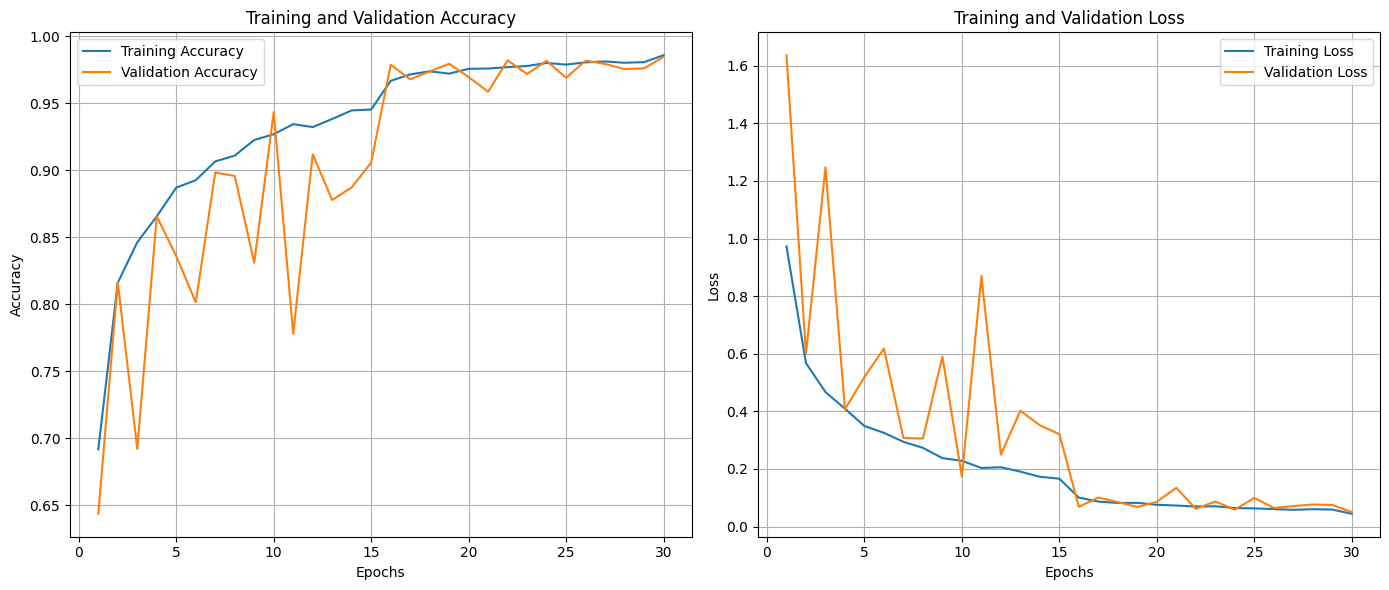

In [19]:
acc = tif_classification_history.history['accuracy']
val_acc = tif_classification_history.history['val_accuracy']
loss = tif_classification_history.history['loss']
val_loss = tif_classification_history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(epochs, acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [21]:
tif_classification_model.save("TIF_classification.h5")   

In [25]:
y_pred_probs = tif_classification_model.predict(test_data_tif_scratch)      
y_pred = np.argmax(y_pred_probs, axis=1) 

87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step


In [26]:
classes_names = [ "AnnualCrop","Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop"  ,"Residential", "River", "SeaLake"]

print("\nClassification Report - TIF Classification\n")
print(classification_report(
    test_label_encoded, 
    y_pred, 
    target_names=classes_names
))


Classification Report - TIF Classification

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.99      0.97       300
              Forest       1.00      1.00      1.00       300
HerbaceousVegetation       0.98      0.97      0.98       300
             Highway       0.98      0.98      0.98       250
          Industrial       1.00      0.98      0.99       250
             Pasture       0.99      0.97      0.98       200
       PermanentCrop       0.99      0.96      0.98       250
         Residential       1.00      1.00      1.00       300
               River       0.97      0.99      0.98       250
             SeaLake       0.99      1.00      1.00       359

            accuracy                           0.98      2759
           macro avg       0.98      0.98      0.98      2759
        weighted avg       0.98      0.98      0.98      2759



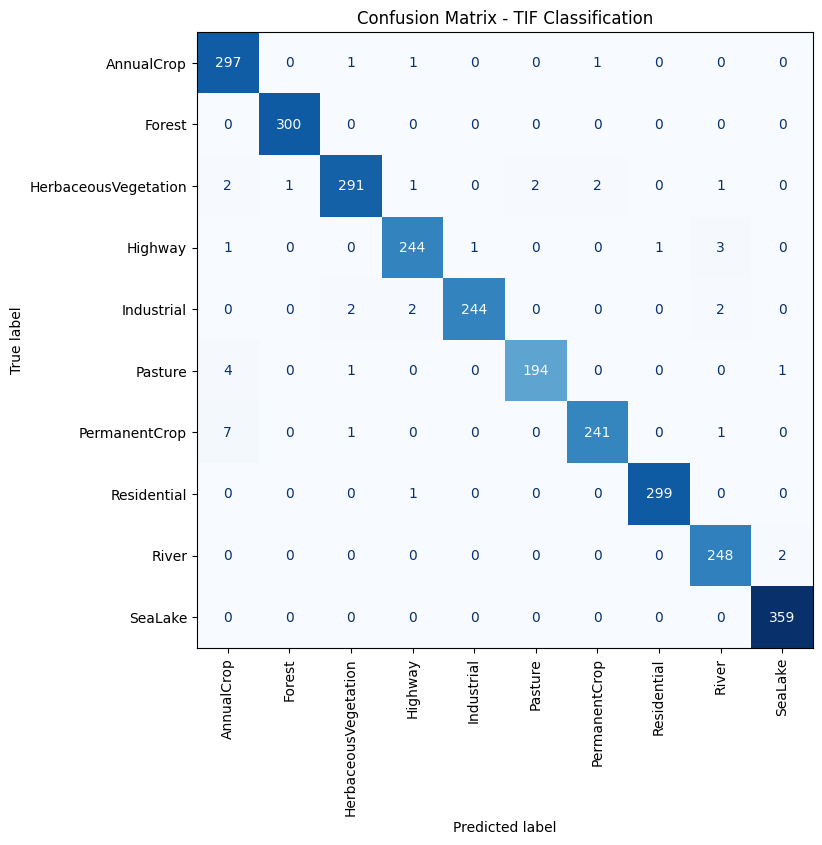

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
disp = ConfusionMatrixDisplay(confusion_matrix(test_label_encoded, y_pred), display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False, values_format="d")
plt.xticks(rotation = 90)
plt.title("Confusion Matrix - TIF Classification")
plt.show()

## **RGB Classification Model** ##

In [29]:
def build_resnet(input_shape=(224, 224, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,     
        pooling='avg'
    )

    x = layers.Dropout(0.3)(base_model.output)
    x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='RGB_Classification')
    return model

In [30]:
rgb_classification_model = build_resnet()

rgb_classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

rgb_classification_model.summary()

Model: "RGB_Classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [36]:
rgb_classification_history = rgb_classification_model.fit(
    train_data_rgb_pretrained,
    validation_data=validation_data_rgb_pretrained,
    epochs=30,
    batch_size = 32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2)
    ],
    verbose=1
)

Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 238s 402ms/step - accuracy: 0.9415 - loss: 0.1926 - val_accuracy: 0.9598 - val_loss: 0.1319 - learning_rate: 2.0000e-04
Epoch 2/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 238s 402ms/step - accuracy: 0.9625 - loss: 0.1259 - val_accuracy: 0.9628 - val_loss: 0.1305 - learning_rate: 2.0000e-04
Epoch 3/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 239s 404ms/step - accuracy: 0.9654 - loss: 0.1208 - val_accuracy: 0.9659 - val_loss: 0.1203 - learning_rate: 2.0000e-04
Epoch 4/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 238s 403ms/step - accuracy: 0.9710 - loss: 0.1025 - val_accuracy: 0.9639 - val_loss: 0.1223 - learning_rate: 2.0000e-04
Epoch 5/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 240s 405ms/step - accuracy: 0.9696 - loss: 0.1019 - val_accuracy: 0.9711 - val_loss: 0.1006 - learning_rate: 2.0000e-04
Epoch 6/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 239s 404ms/step - accuracy: 0.9710 - loss: 0.1004 - val_accuracy: 0.9674 - val_loss: 0.1122 - learning_rate: 2.0000e-04
Epoch 7/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 

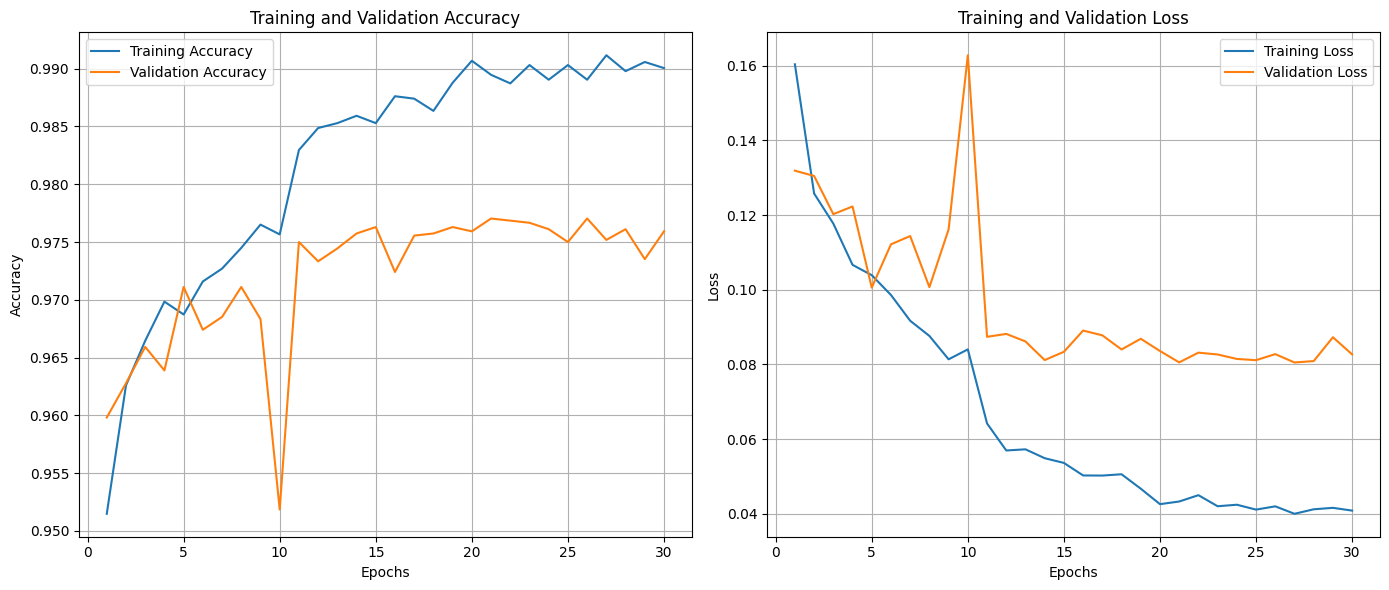

In [38]:
acc = rgb_classification_history.history['accuracy']
val_acc = rgb_classification_history.history['val_accuracy']
loss = rgb_classification_history.history['loss']
val_loss = rgb_classification_history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(epochs, acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [41]:
rgb_classification_model.save("RGB_Classification.h5")   

In [42]:
y_pred_probs = rgb_classification_model.predict(test_data_rgb_pretrained)      
y_pred = np.argmax(y_pred_probs, axis=1) 

85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step


In [50]:
classes_names = [ "AnnualCrop","Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop"  ,"Residential", "River", "SeaLake"]

print("\nClassification Report - RGB Classifier\n")
print(classification_report(
    test_rgb_label_encoded, 
    y_pred, 
    target_names=classes_names
))


Classification Report - RGB Classifier

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.97      0.97       300
              Forest       0.99      1.00      1.00       300
HerbaceousVegetation       0.96      0.98      0.97       300
             Highway       0.98      0.99      0.99       250
          Industrial       1.00      0.98      0.99       250
             Pasture       0.97      0.97      0.97       200
       PermanentCrop       0.96      0.95      0.95       250
         Residential       1.00      1.00      1.00       300
               River       0.99      0.99      0.99       250
             SeaLake       1.00      1.00      1.00       300

            accuracy                           0.98      2700
           macro avg       0.98      0.98      0.98      2700
        weighted avg       0.98      0.98      0.98      2700



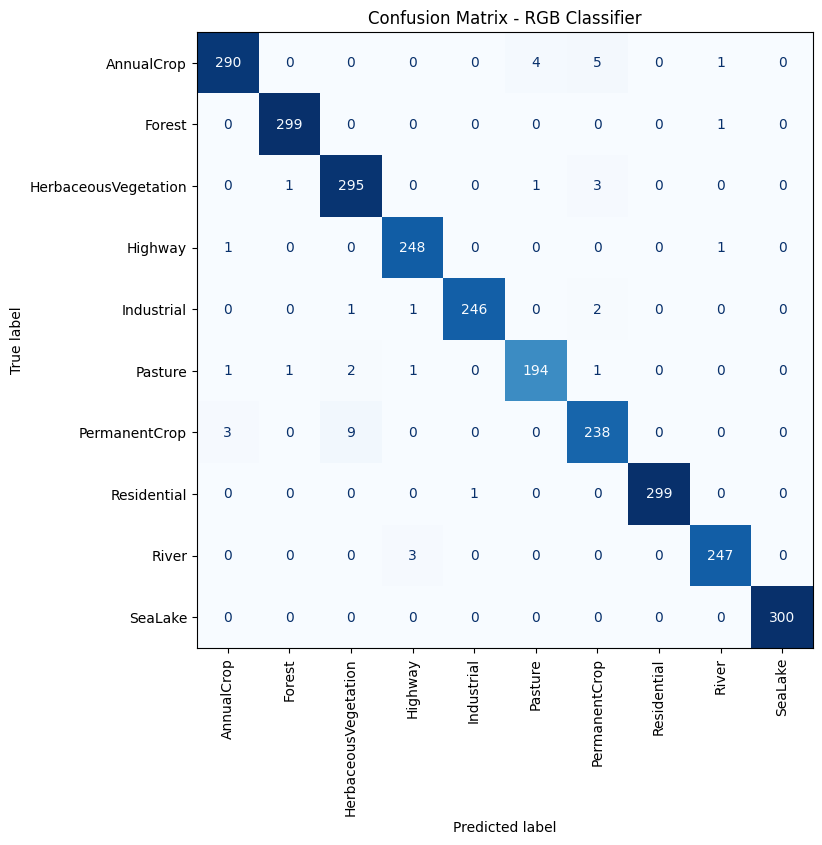

In [49]:
fig, ax = plt.subplots(figsize=(12,8))
disp = ConfusionMatrixDisplay(confusion_matrix(test_rgb_label_encoded, y_pred), display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False, values_format="d")
plt.xticks(rotation = 90)
plt.title("Confusion Matrix - RGB Classifier")
plt.show()